<a href="https://colab.research.google.com/github/peachula/AI-120-FraudDetectionSystem/blob/main/VGG16/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup - Install - Import 

## Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [ ]:
from IPython.display import clear_output

In [ ]:
import shutil
import os

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt
import time
import copy
from torch.autograd import Variable
from PIL import Image
import random
import cv2
import numpy as np 
import pandas as pd
import pywt
from numpy import argmax

In [ ]:
! pip install wandb -qqq
clear_output()

import wandb

# --CONFIG--

In [ ]:
## wandb setting
PROJECT = 'Fake_IC'
GROUP = 'fetch_data'
JOB_TYPE = "fetch_data"
RUN_NAME = 'VGG16'

TAGS = ['VGG16', 'cropped', 'vgg_bn']

CONFIG = {
    "epochs" : 20,
    "input_width": 500,
    "input_height": 300,
    "process_data": "Normal",
}

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN = 'train'
VAL = 'val'
TEST = 'test'

BEST_MODEL_PATH =  'drive/MyDrive/IDCD/fake_ic_detection/VGG16/models/vgg16bn_fake_ic_detect_best.pth'
SAVE_LOG_PATH = 'drive/MyDrive/SunshineTech/IDCD/fake_ic_detection/VGG16/outputs/train_log.txt'
SAVE_IMAGE_PATH = 'mispre_bn'

# Get dataset

## Unzip from drive

In [ ]:
! unzip /content/drive/MyDrive/IDCD/data/interm/MPNet_dataset_recaptured.zip
clear_output()

## Load artifact wandb

In [ ]:
run = wandb.init(project= PROJECT, 
                 group= GROUP,
                 job_type= JOB_TYPE, 
                 tags = TAGS,
                 entity = 'anhntk', 
                 name= RUN_NAME,
                #  id= RUN_ID
                 config = CONFIG,
                 )

In [ ]:
artifact = run.use_artifact('anhntk/Fake_IC/train:v0', type='recaptured_data')
artifact_dir = artifact.download()

artifact = run.use_artifact('anhntk/Fake_IC/val:v0', type='recaptured_data')
artifact_dir = artifact.download()


In [ ]:
artifact = run.use_artifact('anhntk/Fake_IC/test:v0', type='recaptured_data')
artifact_dir = artifact.download()

In [ ]:
run.finish()

## Count files

In [ ]:
for root, dir, files in os.walk("/content/MPNet_dataset_recaptured"):
    print(root)
    print(len(files))

/content/MPNet_dataset_recaptured
0
/content/MPNet_dataset_recaptured/test
0
/content/MPNet_dataset_recaptured/test/real
545
/content/MPNet_dataset_recaptured/test/fake
187
/content/MPNet_dataset_recaptured/train
0
/content/MPNet_dataset_recaptured/train/real
1508
/content/MPNet_dataset_recaptured/train/fake
551
/content/MPNet_dataset_recaptured/val
0
/content/MPNet_dataset_recaptured/val/real
506
/content/MPNet_dataset_recaptured/val/fake
184


# Process data

## Normal process

In [ ]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize((CONFIG["input_height"], CONFIG["input_width"])), ## H, W
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        transforms.Resize((CONFIG["input_height"], CONFIG["input_width"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize((CONFIG["input_height"], CONFIG["input_width"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


## DWT

In [ ]:
class ToDWT(object):
    def __call__(self, img):
        """
        :param img: (PIL): Image 
        Image -> DWT {LL, LH, HL, HH} -> concat -> array
        :return: combine array (array)
        """

        img = img.convert('L')
        img = np.array(img)
        img = cv2.resize(img, (CONFIG["input_width"] * 2 -4, CONFIG["input_height"] * 2 -4)) ## cv2 resize dim(w,h)
        coeffs2 = pywt.dwt2(img, 'bior1.3')
        LL, (LH, HL, HH) = coeffs2     #500x402x4

        ## Merge chanel
        dst = np.array([LH, HL, HH]).transpose(1,2,0)
        return dst

    def __repr__(self):
        return self.__class__.__name__+'()'

In [ ]:
data_transforms = {
    TRAIN: transforms.Compose([
        ToDWT(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        ToDWT(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        ToDWT(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


## ELA

In [ ]:
class ToELA(object):
    def __call__(self, img):
        """
        :param img: (PIL): Image 
        Image -> BGR cv2 -> ELA -> Image
        :return: ELA image (PIL)
        """
        jpg_quality1 = 95
        scale = 15

        img = np.array(img) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        encode_param = [cv2.IMWRITE_JPEG_QUALITY, jpg_quality1]
        _, encimg = cv2.imencode('.jpg', img, encode_param)
        decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
        diff = scale * cv2.absdiff(img, decimg)
        
        img = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)

        return img

    def __repr__(self):
        return self.__class__.__name__+'()'

In [ ]:
data_transforms = {
    TRAIN: transforms.Compose([
        ToELA(),
        transforms.ToPILImage(),
        transforms.Resize((CONFIG["input_height"], CONFIG["input_width"])),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        ToELA(),
        transforms.ToPILImage(),
        transforms.Resize((CONFIG["input_height"], CONFIG["input_width"])),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        ToELA(),
        transforms.ToPILImage(),
        transforms.Resize((CONFIG["input_height"], CONFIG["input_width"])),
        transforms.ToTensor(),
    ]),
}


## DWT + ELA

In [ ]:
class ExtractFeatures(object):
    def __call__(self, img):
        """
        :param img: (PIL): Image 
        Image -> DWT {LL, LH, HL, HH} -> concat -> array
        :return: combine array (array)
        """

        ### dwt
        dwt = img.convert('L')
        dwt = np.array(dwt)
        dwt = cv2.resize(dwt, (CONFIG["input_width"] * 2 -4, CONFIG["input_height"] * 2 -4))
        coeffs2 = pywt.dwt2(dwt, 'bior1.3')
        LL, (LH, HL, HH) = coeffs2     #500x402x4
        dwt = np.array([LH, HL, HH]).transpose(1,2,0)

        ### ELA
        jpg_quality1 = 95
        scale = 15

        ela = np.array(img) 
        ela = cv2.resize(ela, (CONFIG["input_width"], CONFIG["input_height"]))
        ela = cv2.cvtColor(ela, cv2.COLOR_RGB2BGR)
        
        encode_param = [cv2.IMWRITE_JPEG_QUALITY, jpg_quality1]
        _, encimg = cv2.imencode('.jpg', ela, encode_param)
        decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
        diff = scale * cv2.absdiff(ela, decimg)
        # ela = cv2.resize(ela, (500,300))
        dst = np.concatenate((ela, dwt), axis=0)
        return dst

    def __repr__(self):
        return self.__class__.__name__+'()'

In [ ]:
data_transforms = {
    TRAIN: transforms.Compose([
        ExtractFeatures(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        ExtractFeatures(),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        ExtractFeatures(),
        transforms.ToTensor(),
    ]),
}


# Make dataloader

In [ ]:
data_dir = "MPNet_dataset_recaptured"

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [TRAIN,VAL, TEST]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in [TRAIN, VAL, TEST]}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

print(dataset_sizes)
class_names = image_datasets[TRAIN].classes
print(class_names)
num_classes = len(class_names)
print(num_classes)

{'train': 2059, 'val': 690, 'test': 732}
['fake', 'real']
2


In [ ]:
#! ls /content/dataset | wc -l

# Define Functions

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


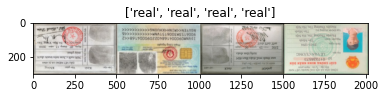

In [ ]:
def imshow(inp,name = None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    if name is not None:
        plt.imsave(name,inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):		
    '''Visualize data on validation set'''	
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[VAL]):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(labels)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Load and redefine layers inmodel

In [ ]:
# vgg16 = torchvision.models.vgg16_bn()
vgg16 = models.vgg16_bn(pretrained=True)
#vgg16.load_state_dict(torch.load("/content/drive/MyDrive/IDCD/Fake_Detection/vgg16/vgg16_bn-6c64b313.pth"))
#print(vgg16.classifier[6].out_features) # 1000 

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier


In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load(BEST_MODEL_PATH))
    print("Loaded!")

if torch.cuda.is_available():
    vgg16.cuda() 

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    
    best_model_wts = copy.deepcopy(model.state_dict())

    ## Early stopping
    best_loss = 100.0
    patience = 2
    trigger_times = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validationidation phase
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evalidationuate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # statistics
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == TRAIN:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float((running_corrects.double() / dataset_sizes[phase]).cpu().detach().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == VAL:
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)

                if (epoch_loss < best_loss):
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), BEST_MODEL_PATH)
                    print('Validation Imporved, save best model ...')

                    print('trigger times: 0')
                    trigger_times = 0
                else:
                  trigger_times += 1
                  print('trigger times: ', trigger_times)

                  if trigger_times >= patience:
                      print('Early stopping! \n ')
                      return model,  loss_train,  acc_train, loss_val,  acc_val, epoch

            elif phase == TRAIN:
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc)
            
        print()  

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train,  acc_train, loss_val,  acc_val, epoch


In [ ]:
loss_train = []
acc_train = []
loss_val = []
acc_val = []

since = time.time()

vgg16, loss_train,  acc_train, loss_val,  acc_val, epoch = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs= CONFIG["epochs"])

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

visualize_model(vgg16)

In [ ]:
# -*- coding: utf-8 -*-
import json

# # Make it work for Python 2+3 and with Unicode
import io
# try:
#     to_unicode = unicode
# except NameError:
#     to_unicode = str

# Define data
data = { 'loss_train': loss_train,
        'acc_train': acc_train,
        'loss_val': loss_val,
        'acc_val': acc_val,
        }

# Write JSON file
with io.open(SAVE_LOG_PATH, 'w', encoding='utf8') as outfile:
    str_ = json.dumps(data,
                      indent=4, sort_keys=True,
                      separators=(',', ': ')
                      # , ensure_ascii=False
                      )
    outfile.write(str_)

# Read JSON file
with open(SAVE_LOG_PATH) as data_file:
    data_loaded = json.load(data_file)

print(data == data_loaded)

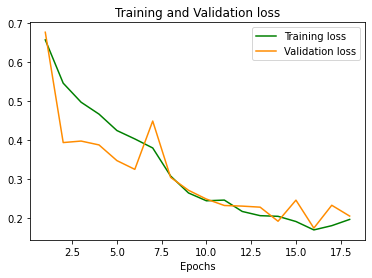

In [ ]:
epochs = range(1, epoch + 2)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'darkorange', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('')
plt.legend()
plt.show()


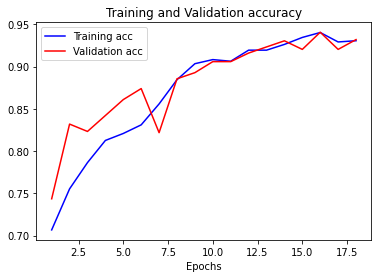

In [ ]:
epochs = range(1, epoch+2)
plt.plot(epochs, acc_train, 'b', label='Training acc')
plt.plot(epochs, acc_val, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('')
plt.legend()
plt.show()


# Testing

In [ ]:
vgg16.load_state_dict(torch.load(BEST_MODEL_PATH, map_location= DEVICE))

<All keys matched successfully>

In [ ]:
vgg16.eval()

In [ ]:
if not os.path.exists(SAVE_IMAGE_PATH):
    os.makedirs(SAVE_IMAGE_PATH)

In [ ]:
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
problist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[TEST]):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = vgg16(inputs)
        _,preds = torch.max(outputs, 1)
        probs =torch.tensor(torch.nn.functional.softmax(outputs, 1)[:,1])
        

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        problist=torch.cat([problist, probs.view(-1).cpu()])

        images_so_far = 0
        fig = plt.figure()
        num_images = 4
        
        #show mislabelèd image
        for j in range(inputs.size()[0]):
                if (preds[j] != labels[j]):
                    imshow(inputs.cpu().data[j], 
                           name = '{}/{}_mislabled_p{}_l{}.png'.format(SAVE_IMAGE_PATH,i, preds[j], labels[j] ),
                           title = '{} predict {} - label {}'.format(i,class_names[preds[j]], class_names[labels[j]] ))
                else:
                    imshow(inputs.cpu().data[j], 
                           title = '{} predict {} - label {}'.format(i,class_names[preds[j]], class_names[labels[j]] ))


Best Threshold=0.342442, F-Score=0.955
Logistic: f1=0.945 auc=0.987


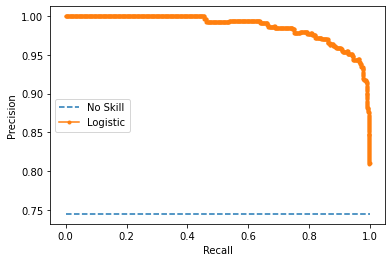

In [ ]:
precision, recall, thresholds = precision_recall_curve(lbllist.numpy(), problist.numpy())
lr_f1, lr_auc = f1_score(lbllist.numpy(), predlist.numpy()), auc(recall, precision)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(lbllist.numpy()[lbllist.numpy()==1]) / len(lbllist.numpy())
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Initialize the prediction and label lists(tensors)
predlist_t=torch.zeros(0,dtype=torch.long, device='cpu')
problist_t=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_t=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[TEST]):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = vgg16(inputs)
        probs =torch.tensor(torch.nn.functional.softmax(outputs, 1)[:,1])
        preds = torch.tensor([0 if prob < thresholds[ix] else 1 for prob in probs])
        
        # Append batch prediction results
        predlist_t=torch.cat([predlist_t,preds])
        lbllist_t=torch.cat([lbllist_t,labels.view(-1).cpu()])
        problist_t=torch.cat([problist_t, probs.view(-1).cpu()])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

#accuracy 
accuracy = accuracy_score(lbllist.numpy(), predlist.numpy())
print(accuracy)

classification_report = classification_report(lbllist.numpy(), predlist.numpy())
print(classification_report)

[[156  31]
 [ 29 516]]
[83.42245989 94.67889908]
0.9180327868852459
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       187
           1       0.94      0.95      0.95       545

    accuracy                           0.92       732
   macro avg       0.89      0.89      0.89       732
weighted avg       0.92      0.92      0.92       732



In [ ]:
# Confusion matrix
conf_mat_t=confusion_matrix(lbllist_t.numpy(), predlist_t.numpy())
print(conf_mat_t)

# Per-class accuracy
class_accuracy_t=100*conf_mat_t.diagonal()/conf_mat_t.sum(1)
print(class_accuracy_t)

#accuracy 
accuracy_t = accuracy_score(lbllist_t.numpy(), predlist_t.numpy())
print(accuracy_t)

classification_report_t = classification_report(lbllist_t.numpy(), predlist_t.numpy())
print(classification_report_t)

[[150  37]
 [ 13 532]]
[80.21390374 97.6146789 ]
0.9316939890710383
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       187
           1       0.93      0.98      0.96       545

    accuracy                           0.93       732
   macro avg       0.93      0.89      0.91       732
weighted avg       0.93      0.93      0.93       732



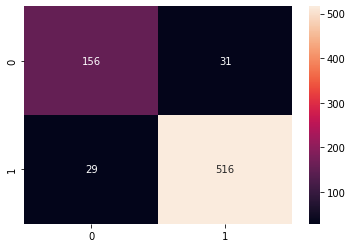

In [ ]:
import seaborn as sns
sns.heatmap(conf_mat, fmt = 'g' ,annot=True)

In [ ]:
! zip -r mispre.zip mispre